In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from scipy.optimize import brentq, minimize
from scipy.stats import norm

# pd.set_option("display.max_rows", None)

In [2]:
options = pd.read_csv(r"data\cleaned_options_data.csv")

# Step 1: Convert the 'ts_recv' column to datetime (this is already optimized)
options["datetime"] = pd.to_datetime(options["ts_recv"], format="%Y-%m-%dT%H:%M:%S.%fZ")

# Step 2: Vectorized parsing of the 'symbol' column
# Split by spaces and extract the relevant parts directly
symbol_parts = options["symbol"].str.split(" ", expand=True)[
    3
]  # Get the fourth part (index 3)

# Extract expiration date (first 6 characters)
options["exp_date"] = pd.to_datetime(symbol_parts.str[:6], format="%y%m%d")

# Extract action ('C' or 'P', at index 6)
options["action"] = symbol_parts.str[6]

# Extract strike price (from index 7 onward, divided by 1000)
options["strike_price"] = symbol_parts.str[7:].astype(float) / 1000

# Step 3: Rename the other columns as needed
options = options.rename(
    columns={
        "bid_px_00": "bidp",
        "ask_px_00": "askp",
        "bid_sz_00": "bid_sz",
        "ask_sz_00": "ask_sz",
    }
)
options["datetime"] = (
    pd.to_datetime(options["datetime"])
    .dt.tz_localize("UTC")
    .dt.tz_convert("US/Eastern")
    .dt.tz_localize(None)
)
options["date"] = options["datetime"].dt.date

# Calculate 'till_exp' (time to expiration in years)
options["till_exp"] = (options["exp_date"] - options["datetime"]).dt.days / 365.0

# Calculate 'fair_value' as the average of bid and ask price
options["fair_value"] = (options["bidp"] + options["askp"]) / 2.0

In [3]:
underlying = pd.read_csv(r"data\spx_minute_level_data_jan_mar_2024.csv")
underlying = underlying.loc[underlying["price"] > 0]
underlying["date"] = pd.to_datetime(underlying["date"], format="%Y%m%d")

underlying = (
    underlying.groupby("date")
    .agg(
        Open=("price", "first"),
        High=("price", "max"),
        Low=("price", "min"),
        Close=("price", "last"),
    )
    .reset_index()
)

In [4]:
indices = underlying["date"].searchsorted(options["datetime"])
indices = indices.clip(0, len(underlying) - 1)
options["underlying"] = underlying["Close"].iloc[indices].values

In [5]:
options["deviate"] = abs(options["underlying"] - options["strike_price"])

In [6]:
min_exp_date_per_group = options.groupby(["date", "action"])["exp_date"].transform(
    "min"
)
result = options[options["exp_date"] == min_exp_date_per_group]
indices = result.groupby(["date", "action", "exp_date"])["deviate"].idxmin()
result = result.loc[indices].reset_index(drop=True)

In [7]:
indices = underlying["date"].searchsorted(result["exp_date"])
indices = indices.clip(0, len(underlying) - 1)
exp_underlyings = underlying["Close"].iloc[indices].values

TODO Make sure to check for:

- Expiration date is before end of interval
- Both call and put exist and have same expiration date
- Deviations from the underlying is below some threshold


In [8]:
profits = []
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # Calculate values based on the given formula
    exp_price = exp_underlyings[i]
    underlying_cost = ccall["askp"] + cput["askp"]
    call_profit = 100 * (exp_price - ccall["strike_price"])
    put_profit = 100 * (cput["strike_price"] - exp_price)
    overall_profit = max(call_profit, 0) + max(put_profit, 0) - underlying_cost

    # Store the calculated profit
    profits.append((ccall["datetime"], overall_profit))

In [9]:
result.columns

Index(['ts_recv', 'instrument_id', 'bidp', 'askp', 'bid_sz', 'ask_sz',
       'symbol', 'datetime', 'exp_date', 'action', 'strike_price', 'date',
       'till_exp', 'fair_value', 'underlying', 'deviate'],
      dtype='object')

In [10]:
orders = pd.DataFrame(columns=["datetime", "option_symbol", "action", "order_size"])
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # IF SOME CONDITION
    if (
        (ccall["exp_date"] >= datetime(2024, 3, 31))
        or (max(ccall["deviate"], cput["deviate"]) > 3.0)
        or (ccall["exp_date"] != cput["exp_date"])
    ):
        continue
    order_size = min(ccall["ask_sz"], cput["ask_sz"])
    new_rows = pd.DataFrame(
        [
            {
                "datetime": ccall["ts_recv"],  # ts_recv for the Call option
                "option_symbol": ccall["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
            {
                "datetime": cput["ts_recv"],  # ts_recv for the Call option
                "option_symbol": cput["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
        ]
    )
    orders = pd.concat(
        [orders, new_rows],
        ignore_index=True,
    )

# Backtesting Code


In [11]:
from datetime import datetime
from backtester import Backtester
from feed_strategy import Strategy

start = datetime(2024, 1, 1)
end = datetime(2024, 3, 30)
s = Strategy(orders)
b = Backtester(start, end, s)

In [12]:
b.calculate_pnl()

2024-01-01 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-02 00:00:00 capital: 99990058.0 portfolio value: 9000.0 total pnl: 99999058.0 open orders: 2
2024-01-03 00:00:00 capital: 99975559.0 portfolio value: 22560.0 total pnl: 99998119.0 open orders: 4
2024-01-04 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-05 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-06 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-07 00:00:00 capital: 99958791.2 portfolio value: 37433.8 total pnl: 99996225.0 open orders: 8
2024-01-08 00:00:00 capital: 99944069.2 portfolio value: 51203.8 total pnl: 99995273.0 open orders: 10
2024-01-09 00:00:00 capital: 99928579.2 portfolio value: 65735.8 total pnl: 99994315.0 open orders: 12
2024-01-10 00:00:00 capital: 99909532.7 portfolio value: 83825.3 total pnl: 99993358.0 op

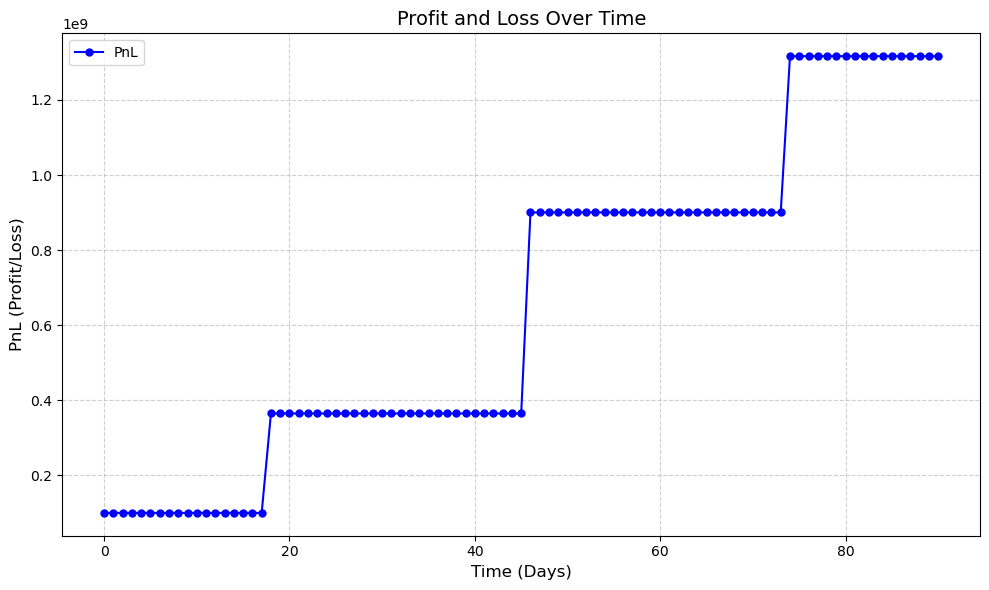

In [13]:
b.plot_pnl()

In [14]:
b.compute_overall_score()

Max Drawdown: 0.000114289999999851
Overall Return: 1216.5357019699218%
Sharpe Ratio: 0.1582830651299907
Overall Score: 1684810.56739973


# Implied Volatility Calculations


In [16]:
# Black-Scholes helper functions
def d1(S, K, T, r, sigma):
    return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


def d2(D1, sigma, T):
    return D1 - sigma * np.sqrt(T)


def black_scholes(S, K, T, r, sigma, option_type):
    D1 = d1(S, K, T, r, sigma)
    D2 = d2(D1, sigma, T)

    if option_type == "C":  # Call option
        return S * norm.cdf(D1) - K * np.exp(-r * T) * norm.cdf(D2)
    else:  # Put option
        return K * np.exp(-r * T) * norm.cdf(-D2) - S * norm.cdf(-D1)


# Vectorized implied volatility calculation
def implied_vol_vectorized(S, K, T, fair_value, r, option_type):
    def error(sigma, S, K, T, r, fair_value, option_type):
        return black_scholes(S, K, T, r, sigma, option_type) - fair_value

    # Apply Brent's method for each row
    implied_vols = []
    for i in range(len(S)):
        try:
            implied_vols.append(
                brentq(
                    error,
                    0.01,
                    1.0,
                    args=(S[i], K[i], T[i], r, fair_value[i], option_type[i]),
                )
            )
        except ValueError:
            implied_vols.append(np.nan)  # Return NaN if no solution
    return np.array(implied_vols)


# Vectorized gamma calculation
def gamma_vectorized(S, K, T, r, sigma):
    D1 = d1(S, K, T, r, sigma)
    return norm.pdf(D1) / (S * sigma * np.sqrt(T))

In [18]:
# Constants
r = 0.03  # Risk-free rate

# Efficient Implied Volatility Calculation
result["impl_vol"] = implied_vol_vectorized(
    result["underlying"],  # Underlying price
    result["strike_price"],  # Strike price
    result["till_exp"],  # Time to expiration
    result["fair_value"],  # Fair value (mid price)
    r,  # Risk-free rate
    result["action"],  # Option type ('C' or 'P')
)

C:\Users\EricS\AppData\Local\Temp\ipykernel_35436\2522160437.py:3: RuntimeWarning: divide by zero encountered in scalar divide
  return (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))


In [20]:
result.head(10)

,ts_recv,instrument_id,bidp,askp,bid_sz,ask_sz,symbol,datetime,exp_date,action,strike_price,date,till_exp,fair_value,underlying,deviate,impl_vol
0,2024-01-02T15:28:14.846635069Z,587248502,72.1,73.3,45,90,SPX 240119C04705000,2024-01-02 10:28:14.846635069,2024-01-19,C,4705.0,2024-01-02,0.043836,72.70,4704.58,0.42,0.177697
1,2024-01-02T14:34:11.497410393Z,587222908,26.2,26.7,328,551,SPX 240119P04705000,2024-01-02 09:34:11.497410393,2024-01-19,P,4705.0,2024-01-02,0.043836,26.45,4704.58,0.42,0.074460
2,2024-01-03T15:38:13.977475868Z,587245121,61.6,62.4,291,210,SPX 240119C04690000,2024-01-03 10:38:13.977475868,2024-01-19,C,4690.0,2024-01-03,0.041096,62.00,4689.20,0.80,0.156926
3,2024-01-03T14:30:28.311225614Z,587203968,27.5,28.0,75,150,SPX 240119P04690000,2024-01-03 09:30:28.311225614,2024-01-19,P,4690.0,2024-01-03,0.041096,27.75,4689.20,0.80,0.079609
4,2024-01-04T19:10:39.414642461Z,587213874,52.4,52.9,212,134,SPX 240119C04695000,2024-01-04 14:10:39.414642461,2024-01-19,C,4695.0,2024-01-04,0.038356,52.65,4696.80,1.80,0.133540
5,2024-01-04T16:20:01.807933424Z,587247089,26.4,26.8,426,378,SPX 240119P04695000,2024-01-04 11:20:01.807933424,2024-01-19,P,4695.0,2024-01-04,0.038356,26.60,4696.80,1.80,0.081985
6,2024-01-05T15:27:59.621086622Z,587239305,18.8,19.3,449,762,SPX 240119C04765000,2024-01-05 10:27:59.621086622,2024-01-19,C,4765.0,2024-01-05,0.035616,19.05,4763.19,1.81,0.048429
7,2024-01-05T14:43:32.053180148Z,587205583,71.7,73.9,45,45,SPX 240119P04765000,2024-01-05 09:43:32.053180148,2024-01-19,P,4765.0,2024-01-05,0.035616,72.80,4763.19,1.81,0.207625
8,2024-01-08T14:30:52.377256535Z,587205568,17.2,17.7,540,477,SPX 240119C04755000,2024-01-08 09:30:52.377256535,2024-01-19,C,4755.0,2024-01-08,0.027397,17.45,4756.05,1.05,0.047278
9,2024-01-08T16:00:14.881105889Z,587239423,48.9,49.8,277,204,SPX 240119P04755000,2024-01-08 11:00:14.881105889,2024-01-19,P,4755.0,2024-01-08,0.027397,49.35,4756.05,1.05,0.164999


In [22]:
orders = pd.DataFrame(columns=["datetime", "option_symbol", "action", "order_size"])
for i in range(0, len(result), 2):
    ccall = result.iloc[i]  # First row (Call)
    cput = result.iloc[i + 1]  # Second row (Put)

    # IF SOME CONDITION
    if (
        (ccall["exp_date"] >= datetime(2024, 3, 31))
        or (max(ccall["deviate"], cput["deviate"]) > 3.0)
        or (ccall["exp_date"] != cput["exp_date"])
        or (ccall["impl_vol"] == np.nan)
        or (cput["impl_vol"] == np.nan)
        or (ccall["impl_vol"] < 0.05)
        or (cput["impl_vol"] < 0.05)
    ):
        continue
    order_size = min(ccall["ask_sz"], cput["ask_sz"])
    new_rows = pd.DataFrame(
        [
            {
                "datetime": ccall["ts_recv"],  # ts_recv for the Call option
                "option_symbol": ccall["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
            {
                "datetime": cput["ts_recv"],  # ts_recv for the Call option
                "option_symbol": cput["symbol"],  # Use the Call option symbol
                "action": "B",  # Action for the Call option
                "order_size": order_size,  # Minimum ask size
            },
        ]
    )
    orders = pd.concat(
        [orders, new_rows],
        ignore_index=True,
    )

In [23]:
s = Strategy(orders)
b = Backtester(start, end, s)

In [24]:
b.calculate_pnl()

2024-01-01 00:00:00 capital: 100000000 portfolio value: 0 total pnl: 100000000 open orders: 0
2024-01-02 00:00:00 capital: 99990058.0 portfolio value: 9000.0 total pnl: 99999058.0 open orders: 2
2024-01-03 00:00:00 capital: 99975559.0 portfolio value: 22560.0 total pnl: 99998119.0 open orders: 4
2024-01-04 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-05 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-06 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-07 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-08 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-09 00:00:00 capital: 99963939.2 portfolio value: 33239.8 total pnl: 99997179.0 open orders: 6
2024-01-10 00:00:00 capital: 99944892.7 portfolio value: 51329.3 total pnl: 99996222.0 open

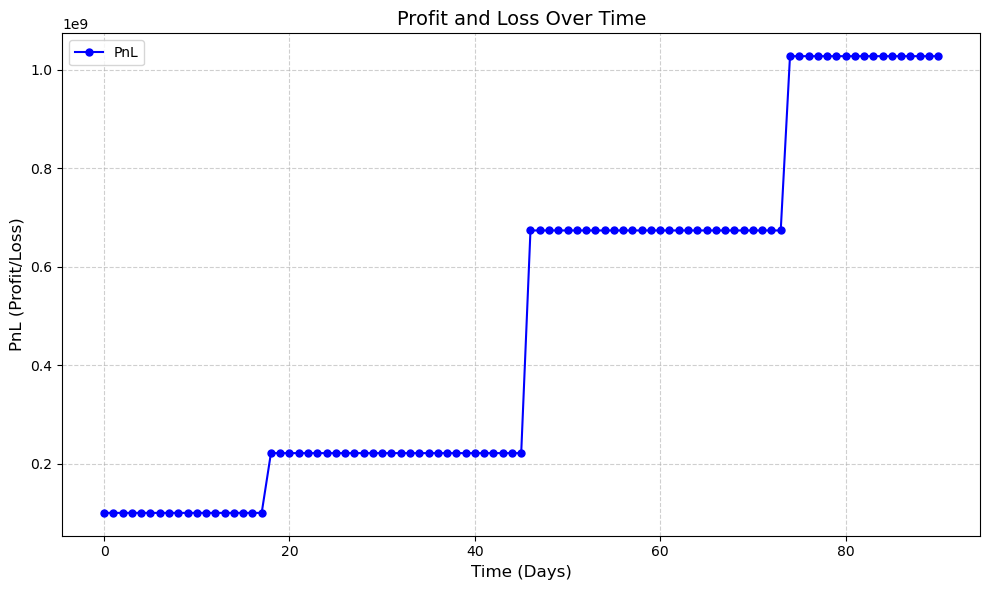

In [25]:
b.plot_pnl()

In [26]:
b.compute_overall_score()

Max Drawdown: 7.6079999999851e-05
Overall Return: 927.2162523085937%
Sharpe Ratio: 0.16464657765317234
Overall Score: 2006611.2340603222
